In [1]:
import mplfinance as mpf
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
API_keys = open('API_KEYS.txt',"r").read().split()

In [3]:
# Runs through stock data and calls strategies and graphs
def algorithims(ticker,cash,show_transactions,show_graphs):
    # Loads in dataframe and renames columns
    API_key = API_keys[random.randint(0,8)]
    time = TimeSeries(key = API_key,output_format='pandas')
    data = time.get_intraday(symbol=ticker,interval='1min',outputsize='full')[0].rename(columns={"1. open":"Open","2. high":"High","3. low":"Low","4. close":"Close","5. volume":"Volume"})
    data = data.sort_index()
    # Splits dataframe into a list of dataframes of each day
    days = [group[1] for group in data.groupby(data.index.dayofyear)]
    num_days = len(days) 
    # Initialize returns for strategies
    strategy1_returns = np.empty(0)
    strategy2_returns = np.empty(0)
    strategy3_returns = np.empty(0)
    strategy4_returns = np.empty(0)
    market_returns = np.empty(0)
    # Loops through dataframes and performs strategies and graphs
    for df in days:
        # Limits data to only during trading hours
        df = df.loc[(df.index >= f'{df.index.date[0]} 9:30:00')]
        df = df.loc[(df.index <= f'{df.index.date[0]} 16:00:00')]   
        # Aggregates one minutes 
        df = df.resample('5T').agg({'Open':'first','High':'max','Low':'min','Close':'last','Volume':'sum'})  
        # Add calculated columns for desired indicators 
        df['VWAP'] = (((df['High']+df['Low']+df['Close'])*df['Volume']/3).cumsum())/df['Volume'].cumsum()
        df['percent'] = ((df['Close'])-df['VWAP'])/df['VWAP']
        df['TWAP'] = ((df['Open'] + df['High'] + df['Low'] + df['Close'])/4).expanding().mean()
        df["EMA10"] = df['Close'].ewm(span=10, adjust=False).mean()
        df["EMA20"] = df['Close'].ewm(span=20, adjust=False).mean()
        

        df = df.dropna()
        # Plot indicators and price
        if show_graphs:
            title = f'{df.index[0].month_name()} {df.index[0].day}, {data.index[0].year} {ticker}'
            vwap = mpf.make_addplot(df['VWAP'])
            twap = mpf.make_addplot(df['TWAP'])
            ema10 = mpf.make_addplot(df['EMA10'])
            ema20 = mpf.make_addplot(df['EMA20'])
            fig, axes = mpf.plot(df,addplot=[vwap,twap,ema10,ema20],type='candle',style='yahoo',volume=True,title=title,returnfig=True)
            axes[0].legend( ['VWAP','TWAP','EMA10','EMA20'] )
            plt.show()
              
        # Run strategies and add up returns using numpy arrays
        strategy1_returns = np.append(strategy1_returns,strategy1(df,ticker,cash/num_days,show_transactions))
        strategy2_returns = np.append(strategy2_returns,strategy2(df,ticker,cash/num_days,show_transactions))
        strategy3_returns = np.append(strategy3_returns,strategy3(df,ticker,cash/num_days,show_transactions))
        strategy4_returns = np.append(strategy4_returns,strategy4(df,ticker,cash/num_days,show_transactions))
        market_returns = np.append(market_returns,market(df,ticker,cash/num_days))
    # Plots the price of the stock over the period
    if show_graphs:
        title = f'{data.index[0].month_name()} {data.index[0].day}, {data.index[0].year}-{data.index[-1].month_name()} {data.index[-1].day}, {data.index[-1].year} {ticker}'
        mpf.plot(data,type='line',style='yahoo',title=title)
    returns = np.array([strategy1_returns,strategy2_returns,strategy3_returns,strategy4_returns,market_returns])
    return returns 

In [4]:
# VWAP Cross:
# Long when price crosses above VWAP and short when VWAP goes below
def strategy1(df,ticker,cash,show_transactions):
    # Prints which day this is
    date = df.index.date[0]
    if show_transactions:
        print(f'{date}: Starting VWAP Cross strategy with ${cash} USD')
    # Initialize variables
    i = 0
    cash0 = cash
    shares = 0
    shorts = 0
    transactions = 0
    for index,row in df.iterrows():
        if (not i): 
            # sets initial position based on inital VWAP and price
            long = row['VWAP'] < row['Close'] 
            short = not long
            transactions += 1
            i += 1
            if long:
                shares = cash/row['Close']
                cash = 0
                if show_transactions:
                    print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            if short:
                shorts = cash/row['Close']
                cash = cash0*2
                if show_transactions:
                    print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
        # Long position 
        if ((row['VWAP'] < row['Open']) and (row['VWAP'] < row['Close']) and short):
            if show_transactions:
                print(f"{index.time()}: Close {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
            cash -= shorts*row['Close']
            shares = cash/row['Close']
            shorts = 0
            long = True   
            short = not long
            if show_transactions:
                print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            transactions += 2
        # Short position
        if ((row['VWAP'] > row['Open']) and (row['VWAP'] > row['Close']) and long):
            if show_transactions:
                print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
            cash = shares*row['Close']*2
            shorts = shares
            shares = 0       
            short = True
            long = not short
            if show_transactions:
                print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
            transactions += 2
        price = row['Close']
    # Exit position and calculate returns
    if short: 
        if show_transactions:
            print(f"{index.time()}: Close {shorts:.3f} {ticker} short contracts at {price} per contract")
        cash -= shorts*price
    if long:
        if show_transactions:
            print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
        cash = shares*price
    transactions += 1
    returns = (cash - cash0)/cash0
    if show_transactions:
        print(f'Cash: {cash}')
        print(f'Return: {returns*100:.2f}%')
        print(f'Transactions: {transactions}')
        print('-'*70)
    return cash

In [5]:
# VWAP Mean Reversion: 
# Long at troughs and short at peaks with assumption that price will return to VWAP
def strategy2(df,ticker,cash,show_transactions):
    # Prints which day this is
    date = df.index.date[0]
    if show_transactions:
        print(f'{date}: Starting VWAP Mean reversion with ${cash} USD')
    # Initialize variables
    i = 0
    cash0 = cash
    shares = 0
    shorts = 0
    transactions = 0
    percent_from_mean = 0.01
    for index,row in df.iterrows():
        if (not i): 
            # sets initial position based on inital VWAP and price
            long = row['VWAP'] > row['Close'] 
            short = not long
            transactions += 1
            i += 1
            if long:
                shares = cash/row['Close']
                cash = 0
                if show_transactions:
                    print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            if short:
                shorts = cash/row['Close']
                cash = cash0*2
                if show_transactions:
                    print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
        # Long position 
        if ((row['percent'] < -(percent_from_mean)) and short):
            if show_transactions:
                print(f"{index.time()}: Close {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
            cash -= shorts*row['Close']
            shares = cash/row['Close']
            shorts = 0
            long = True   
            short = not long
            if show_transactions:
                print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            transactions += 2
        # Short position
        if ((row['percent'] > percent_from_mean) and long):
            if show_transactions:
                print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
            cash = shares*row['Close']*2
            shorts = shares
            shares = 0       
            short = True
            long = not short
            if show_transactions:
                print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
            transactions += 2
        price = row['Close']
    # Exit position and calculate returns
    if short: 
        if show_transactions:
            print(f"{index.time()}: Close {shorts:.3f} {ticker} short contracts at {price} per contract")
        cash -= shorts*price
    if long:
        if show_transactions:
            print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
        cash = shares*price
    transactions += 1
    returns = (cash - cash0)/cash0
    if show_transactions:
        print(f'Cash: {cash}')
        print(f'Return: {returns*100:.2f}%')
        print(f'Transactions: {transactions}')
        print('-'*70)
    return cash

In [6]:
# EMA
# Uses the cross of a fast (10Day) and slow (20Day) moving as a signal to buy or sell
def strategy3(df,ticker,cash,show_transactions):
    # Prints which day this is
    date = df.index.date[0]
    if show_transactions:
        print(f'{date}: Starting EMA Cross strategy with ${cash} USD')
    # Initialize variables
    i = 0
    cash0 = cash
    shares = 0
    transactions = 0
    for index,row in df.iterrows():
        # if (not i): 
            # sets initial position based on inital VWAP and price
            # long = row['VWAP'] < row['Close'] 
            # short = not long
            # transactions += 1
            # i += 1
            # if long:
            #     shares = cash/row['Close']
            #     cash = 0
            #     if show_transactions:
            #         print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            # if short:
            #     shorts = cash/row['Close']
            #     cash = cash0*2
            #     if show_transactions:
            #         print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
        # Buy position 
        if ( ( row['EMA10'] > row['EMA20'] ) and cash ):
            shares = cash/row['Close']
            cash = 0
            if show_transactions:
                print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            transactions += 1
        
        # Sell position
        if ( ( row['EMA10'] < row['EMA20'] ) and not cash):
            cash = shares*row['Close']
            if show_transactions:
                print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share") 
            shares = 0
            transactions += 1
        price = row['Close']
    # Exit position and calculate returns
    if show_transactions:
        print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
    cash += shares*price
    transactions += 1
    returns = (cash - cash0)/cash0
    if show_transactions:
        print(f'Cash: {cash}')
        print(f'Return: {returns*100:.2f}%')
        print(f'Transactions: {transactions}')
        print('-'*70)
    return cash

In [7]:
# TWAP + VWAP strategy

# Long when price is greater than VWAP and TWAP and VWAP > TWAP
# Short when price is less than VWAP and TWAP and VWAP < TWAP

def strategy4(df,ticker,cash,show_transactions):
    # Prints which day this is
    date = df.index.date[0]
    if show_transactions:
        print(f'{date}: Starting VWAP + TWAP strategy with ${cash} USD')
    # Initialize variables
    i = 0
    cash0 = cash
    shares = 0
    shorts = 0
    transactions = 0
    for index,row in df.iterrows():
        if (not i): 
            # sets initial position based on inital VWAP and price
            # go long if price is above VWAP and TWAP and VWAP > TWAP
            long = row['VWAP'] > row['TWAP'] and row['Close'] > row['VWAP']
            short = not long
            transactions += 1
            i += 1
            if long:
                shares = cash/row['Close']
                cash = 0
                if show_transactions:
                    print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            if short:
                shorts = cash/row['Close']
                cash = cash0*2
                if show_transactions:
                    print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
                    
        # Long position 
        if ((row['VWAP'] < row['Open']) and (row['VWAP'] < row['Close']) and short and (row['VWAP'] > row['TWAP'])):
            if show_transactions:
                print(f"{index.time()}: Close {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
            cash -= shorts*row['Close']
            shares = cash/row['Close']
            shorts = 0
            long = True   
            short = not long
            if show_transactions:
                print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            transactions += 2
            
        # Short position
        if ((row['VWAP'] > row['Open']) and (row['VWAP'] > row['Close']) and long and (row['VWAP'] < row['TWAP'])):
            if show_transactions:
                print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
            cash = shares*row['Close']*2
            shorts = shares
            shares = 0       
            short = True
            long = not short
            if show_transactions:
                print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
            transactions += 2
        price = row['Close']
        
    # Exit position and calculate returns
    if short: 
        if show_transactions:
            print(f"{index.time()}: Close {shorts:.3f} {ticker} short contracts at {price} per contract")
        cash -= shorts*price
    if long:
        if show_transactions:
            print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
        cash = shares*price
    transactions += 1
    returns = (cash - cash0)/cash0
    if show_transactions:
        print(f'Cash: {cash}')
        print(f'Return: {returns*100:.2f}%')
        print(f'Transactions: {transactions}')
        print('-'*70)
    return cash

In [8]:
# Market Performance:
# Returns if you bought at open and sold at close
def market(df,ticker,cash):
    open_price = df['Open'].loc[f'{df.index.date[0]} 9:30:00']
    shares = cash/open_price
    close_price = df['Close'].loc[f'{df.index.date[0]} 16:00:00']
    return shares*close_price

In [9]:
# Prints returns for each strategy for one stock at a time
def print_stock_returns(ticker,returns,cash_per_stock):
    print(f'{ticker} Returns')
    for i in range(0,returns.shape[0]-1):
        print(f'Strategy {i+1}: {(np.sum(returns[i]) - cash_per_stock)*100/cash_per_stock:.3f}%')
    print(f'Market    : {(np.sum(returns[-1]) - cash_per_stock)*100/cash_per_stock:.3f}%')
    print('-'*50)

In [10]:
# Prints returns for each strategy overall
def print_summary_returns(all_returns,cash):
    strat1 = 0
    strat2 = 0
    strat3 = 0
    strat4 = 0
    market = 0
    for i in range(0,all_returns.shape[0]):
        if i % 5 == 0:
            strat1 += all_returns[i].sum()
        if i % 5 == 1:
            strat2 += all_returns[i].sum()
        if i % 5 == 2:
            strat3 += all_returns[i].sum()
        if i % 5 == 3:
            strat4 += all_returns[i].sum()
        if i % 5 == 4:
            market += all_returns[i].sum()
    print('Portfolio Returns')
    print(f'Strategy 1: {(strat1-cash)*100/cash:.3f}%')
    print(f'Strategy 2: {(strat2-cash)*100/cash:.3f}%')
    print(f'Strategy 3: {(strat3-cash)*100/cash:.3f}%')
    print(f'Strategy 4: {(strat4-cash)*100/cash:.3f}%')
    print(f'Market    : {(market-cash)*100/cash:.3f}%')

In [11]:
# Calls algorithims function and prints returns using print functions
def main(stocks,cash,show_transactions=False,show_graphs=False):
    # Initializes numpy arrays for returns
    returns = np.empty((0,0))
    all_returns = np.empty((0,10))
    cash_per_stock = cash/len(stocks)
    for ticker in stocks:
        returns = algorithims(ticker,cash_per_stock,show_transactions,show_graphs)
        all_returns = np.append(all_returns,returns,axis=0)
        print_stock_returns(ticker,returns,cash_per_stock)
    print_summary_returns(all_returns,cash)

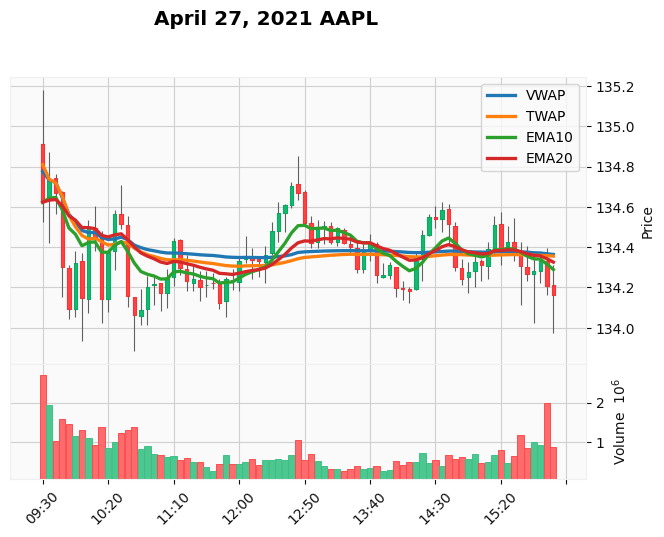

2021-04-27: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 37.141 AAPL short contracts at 134.6225 per contract
10:30:00: Close 37.141 AAPL short contracts at 134.5127 per contract
10:30:00: Buy 37.202 AAPL shares at 134.5127 per share
10:40:00: Sell 37.202 AAPL shares at 134.0635 per share
10:40:00: Open 37.202 AAPL short contracts at 134.0635 per contract
12:25:00: Close 37.202 AAPL short contracts at 134.4811 per contract
12:25:00: Buy 36.970 AAPL shares at 134.4811 per share
13:50:00: Sell 36.970 AAPL shares at 134.2634 per share
13:50:00: Open 36.970 AAPL short contracts at 134.2634 per contract
14:25:00: Close 36.970 AAPL short contracts at 134.5477 per contract
14:25:00: Buy 36.814 AAPL shares at 134.5477 per share
14:50:00: Sell 36.814 AAPL shares at 134.2433 per share
14:50:00: Open 36.814 AAPL short contracts at 134.2433 per contract
15:15:00: Close 36.814 AAPL short contracts at 134.5077 per contract
15:15:00: Buy 36.670 AAPL shares at 134.5077 per share
15:35:

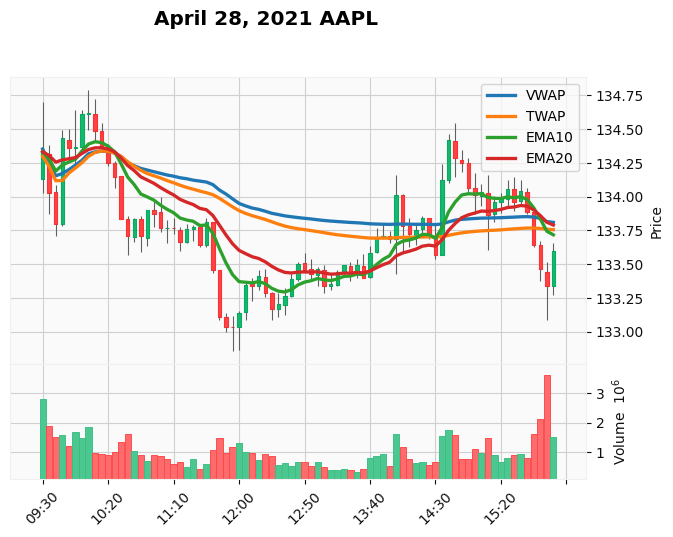

2021-04-28: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 37.221 AAPL short contracts at 134.333 per contract
09:50:00: Close 37.221 AAPL short contracts at 134.358 per contract
09:50:00: Buy 37.207 AAPL shares at 134.358 per share
10:25:00: Sell 37.207 AAPL shares at 134.1434 per share
10:25:00: Open 37.207 AAPL short contracts at 134.1434 per contract
14:40:00: Close 37.207 AAPL short contracts at 134.4179 per contract
14:40:00: Buy 37.055 AAPL shares at 134.4179 per share
15:50:00: Sell 37.055 AAPL shares at 133.4645 per share
15:50:00: Open 37.055 AAPL short contracts at 133.4645 per contract
16:00:00: Close 37.055 AAPL short contracts at 133.5943 per contract
Cash: 4940.733384903729
Return: -1.19%
Transactions: 10
----------------------------------------------------------------------
2021-04-28: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Buy 37.221 AAPL shares at 134.333 per share
16:00:00: Sell 37.221 AAPL shares at 133.5943 per share
Cash: 4972.504894

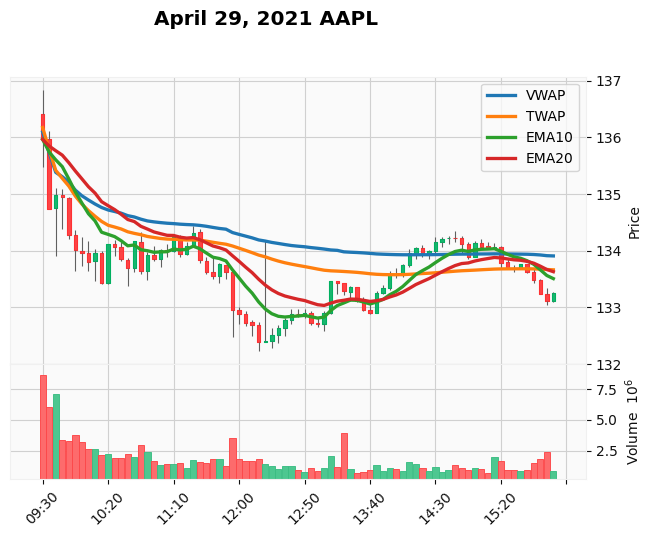

2021-04-29: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 36.775 AAPL short contracts at 135.9603 per contract
14:15:00: Close 36.775 AAPL short contracts at 134.0485 per contract
14:15:00: Buy 37.824 AAPL shares at 134.0485 per share
15:25:00: Sell 37.824 AAPL shares at 133.6941 per share
15:25:00: Open 37.824 AAPL short contracts at 133.6941 per contract
16:00:00: Close 37.824 AAPL short contracts at 133.2549 per contract
Cash: 5073.51479937786
Return: 1.47%
Transactions: 6
----------------------------------------------------------------------
2021-04-29: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Buy 36.775 AAPL shares at 135.9603 per share
16:00:00: Sell 36.775 AAPL shares at 133.2549 per share
Cash: 4900.507721739361
Return: -1.99%
Transactions: 2
----------------------------------------------------------------------
2021-04-29: Starting EMA Cross strategy with $5000.0 USD
13:50:00: Buy 37.497 AAPL shares at 133.3447 per share
15:45:00: Sell 37.497 AAPL

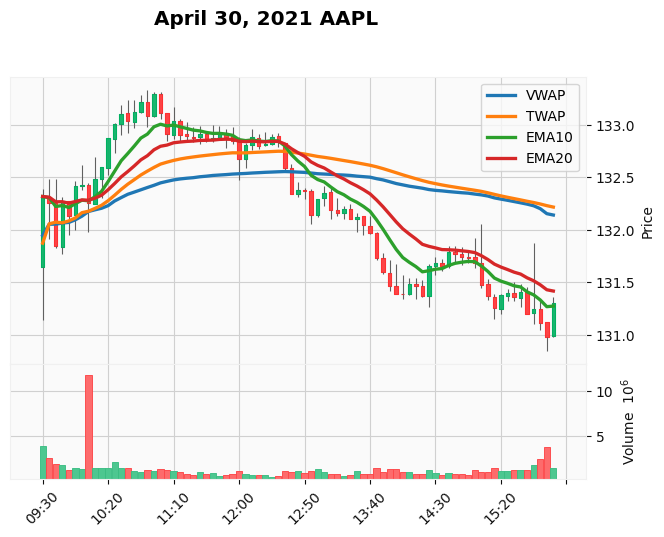

2021-04-30: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Buy 37.788 AAPL shares at 132.3164 per share
12:45:00: Sell 37.788 AAPL shares at 132.3763 per share
12:45:00: Open 37.788 AAPL short contracts at 132.3763 per contract
16:00:00: Close 37.788 AAPL short contracts at 131.2982 per contract
Cash: 5043.002983757114
Return: 0.86%
Transactions: 4
----------------------------------------------------------------------
2021-04-30: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Open 37.788 AAPL short contracts at 132.3164 per contract
16:00:00: Close 37.788 AAPL short contracts at 131.2982 per contract
Cash: 5038.475956117306
Return: 0.77%
Transactions: 2
----------------------------------------------------------------------
2021-04-30: Starting EMA Cross strategy with $5000.0 USD
10:10:00: Buy 37.740 AAPL shares at 132.4861 per share
12:35:00: Sell 37.740 AAPL shares at 132.586 per share
16:00:00: Sell 0.000 AAPL shares at 131.2982 per share
Cash: 5003.7702068367935
Re

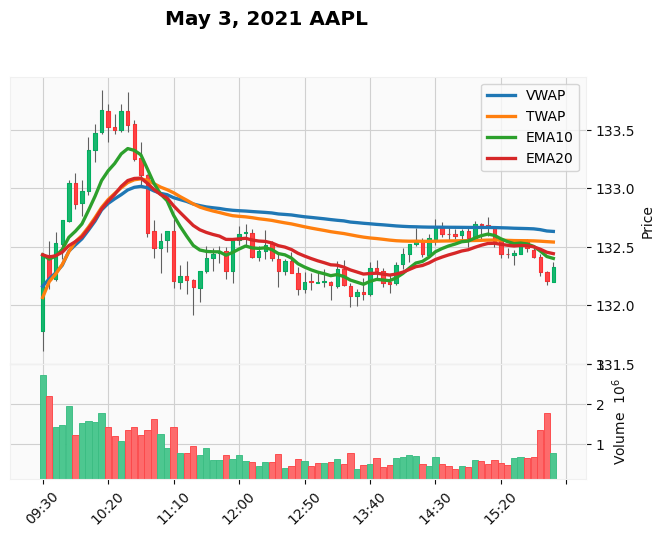

2021-05-03: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Buy 37.755 AAPL shares at 132.4312 per share
10:55:00: Sell 37.755 AAPL shares at 132.4862 per share
10:55:00: Open 37.755 AAPL short contracts at 132.4862 per contract
15:05:00: Close 37.755 AAPL short contracts at 132.6858 per contract
15:05:00: Buy 37.642 AAPL shares at 132.6858 per share
15:20:00: Sell 37.642 AAPL shares at 132.4362 per share
15:20:00: Open 37.642 AAPL short contracts at 132.4362 per contract
16:00:00: Close 37.642 AAPL short contracts at 132.3264 per contract
Cash: 4989.278229143233
Return: -0.21%
Transactions: 8
----------------------------------------------------------------------
2021-05-03: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Open 37.755 AAPL short contracts at 132.4312 per contract
16:00:00: Close 37.755 AAPL short contracts at 132.3264 per contract
Cash: 5003.9567715160765
Return: 0.08%
Transactions: 2
----------------------------------------------------------------------

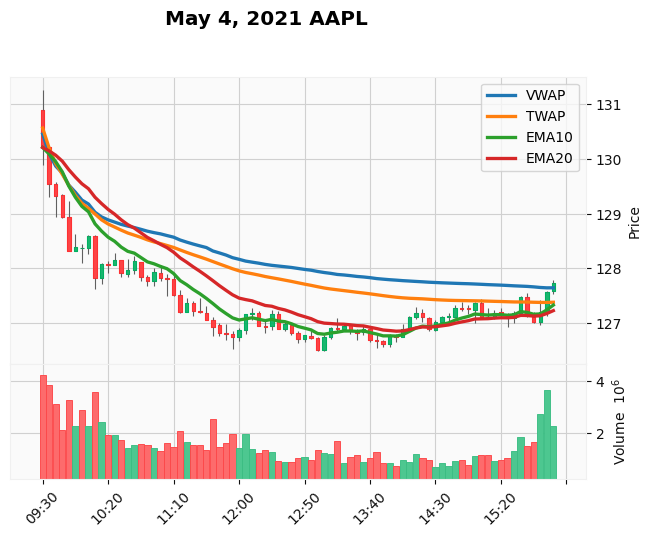

2021-05-04: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 38.400 AAPL short contracts at 130.21 per contract
16:00:00: Close 38.400 AAPL short contracts at 127.7242 per contract
Cash: 5095.453498195224
Return: 1.91%
Transactions: 2
----------------------------------------------------------------------
2021-05-04: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Buy 38.400 AAPL shares at 130.21 per share
16:00:00: Sell 38.400 AAPL shares at 127.7242 per share
Cash: 4904.546501804776
Return: -1.91%
Transactions: 2
----------------------------------------------------------------------
2021-05-04: Starting EMA Cross strategy with $5000.0 USD
14:20:00: Buy 39.337 AAPL shares at 127.1052 per share
16:00:00: Sell 39.337 AAPL shares at 127.7242 per share
Cash: 5024.349908579665
Return: 0.49%
Transactions: 2
----------------------------------------------------------------------
2021-05-04: Starting VWAP + TWAP strategy with $5000.0 USD
09:30:00: Open 38.400 AAPL short cont

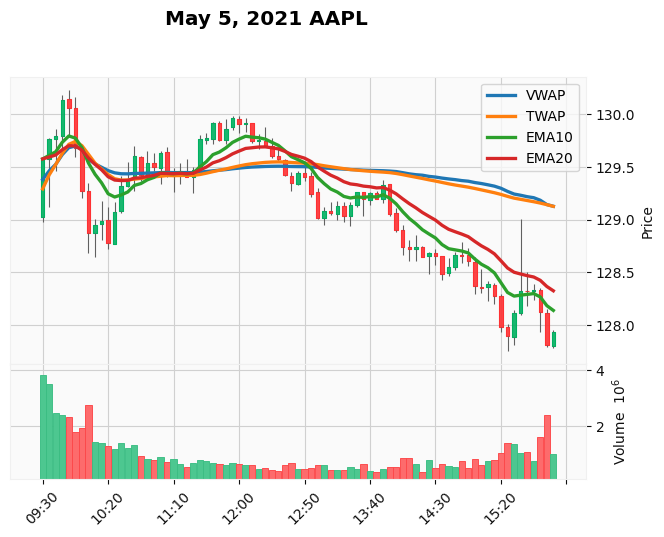

2021-05-05: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Buy 38.588 AAPL shares at 129.5741 per share
10:05:00: Sell 38.588 AAPL shares at 128.8757 per share
10:05:00: Open 38.588 AAPL short contracts at 128.8757 per contract
10:55:00: Close 38.588 AAPL short contracts at 129.4995 per contract
10:55:00: Buy 38.216 AAPL shares at 129.4995 per share
11:10:00: Sell 38.216 AAPL shares at 129.4213 per share
11:10:00: Open 38.216 AAPL short contracts at 129.4213 per contract
11:30:00: Close 38.216 AAPL short contracts at 129.7607 per contract
11:30:00: Buy 38.016 AAPL shares at 129.7607 per share
12:40:00: Sell 38.016 AAPL shares at 129.3415 per share
12:40:00: Open 38.016 AAPL short contracts at 129.3415 per contract
16:00:00: Close 38.016 AAPL short contracts at 127.9338 per contract
Cash: 4970.599014369485
Return: -0.59%
Transactions: 12
----------------------------------------------------------------------
2021-05-05: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Ope

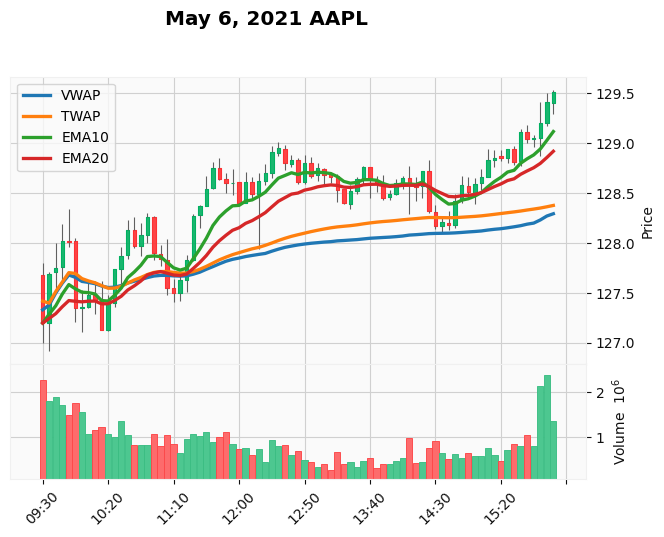

2021-05-06: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 39.310 AAPL short contracts at 127.1951 per contract
09:40:00: Close 39.310 AAPL short contracts at 127.7442 per contract
09:40:00: Buy 38.972 AAPL shares at 127.7442 per share
10:00:00: Sell 38.972 AAPL shares at 127.3548 per share
10:00:00: Open 38.972 AAPL short contracts at 127.3548 per contract
10:30:00: Close 38.972 AAPL short contracts at 127.864 per contract
10:30:00: Buy 38.661 AAPL shares at 127.864 per share
11:10:00: Sell 38.661 AAPL shares at 127.4996 per share
11:10:00: Open 38.661 AAPL short contracts at 127.4996 per contract
11:25:00: Close 38.661 AAPL short contracts at 128.2683 per contract
11:25:00: Buy 38.198 AAPL shares at 128.2683 per share
16:00:00: Sell 38.198 AAPL shares at 129.5112 per share
Cash: 4947.064106020177
Return: -1.06%
Transactions: 12
----------------------------------------------------------------------
2021-05-06: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Buy 3

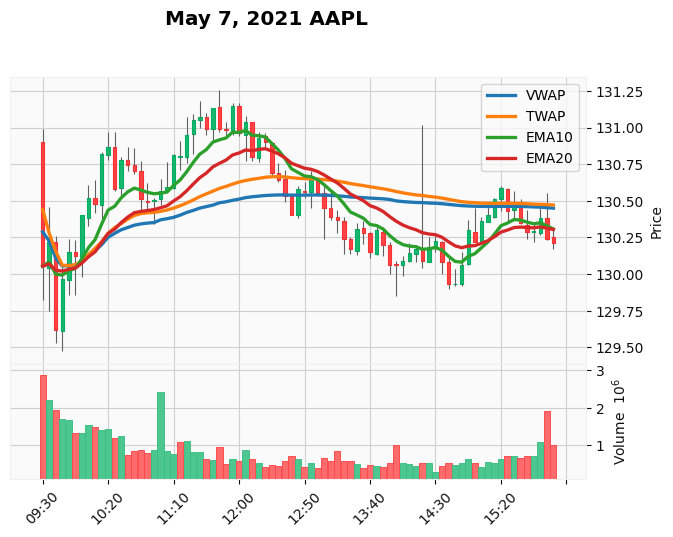

2021-05-07: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 38.446 AAPL short contracts at 130.0535 per contract
09:55:00: Close 38.446 AAPL short contracts at 130.12 per contract
09:55:00: Buy 38.406 AAPL shares at 130.12 per share
12:40:00: Sell 38.406 AAPL shares at 130.4 per share
12:40:00: Open 38.406 AAPL short contracts at 130.4 per contract
12:50:00: Close 38.406 AAPL short contracts at 130.56 per contract
12:50:00: Buy 38.312 AAPL shares at 130.56 per share
13:10:00: Sell 38.312 AAPL shares at 130.39 per share
13:10:00: Open 38.312 AAPL short contracts at 130.39 per contract
15:20:00: Close 38.312 AAPL short contracts at 130.59 per contract
15:20:00: Buy 38.195 AAPL shares at 130.59 per share
15:40:00: Sell 38.195 AAPL shares at 130.29 per share
15:40:00: Open 38.195 AAPL short contracts at 130.29 per contract
16:00:00: Close 38.195 AAPL short contracts at 130.21 per contract
Cash: 4979.473698481709
Return: -0.41%
Transactions: 14
---------------------------------

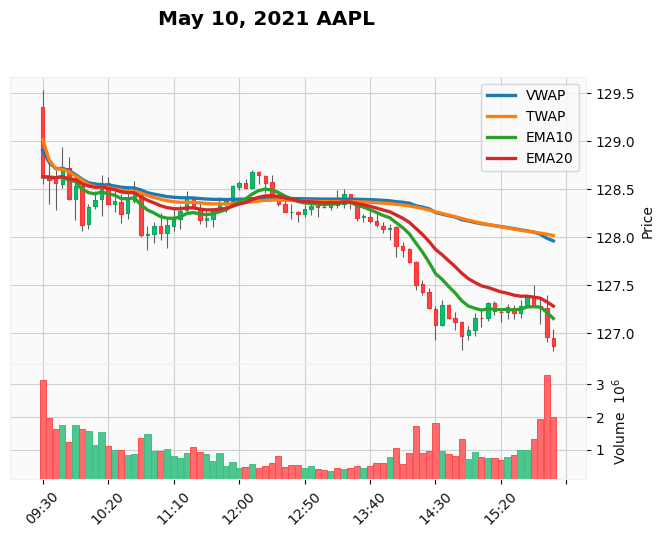

2021-05-10: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 38.871 AAPL short contracts at 128.63 per contract
12:00:00: Close 38.871 AAPL short contracts at 128.57 per contract
12:00:00: Buy 38.907 AAPL shares at 128.57 per share
12:35:00: Sell 38.907 AAPL shares at 128.265 per share
12:35:00: Open 38.907 AAPL short contracts at 128.265 per contract
16:00:00: Close 38.907 AAPL short contracts at 126.86 per contract
Cash: 5045.130478040665
Return: 0.90%
Transactions: 6
----------------------------------------------------------------------
2021-05-10: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Buy 38.871 AAPL shares at 128.63 per share
16:00:00: Sell 38.871 AAPL shares at 126.86 per share
Cash: 4931.198009795538
Return: -1.38%
Transactions: 2
----------------------------------------------------------------------
2021-05-10: Starting EMA Cross strategy with $5000.0 USD
09:45:00: Buy 38.841 AAPL shares at 128.7297 per share
09:50:00: Sell 38.841 AAPL shares at 12

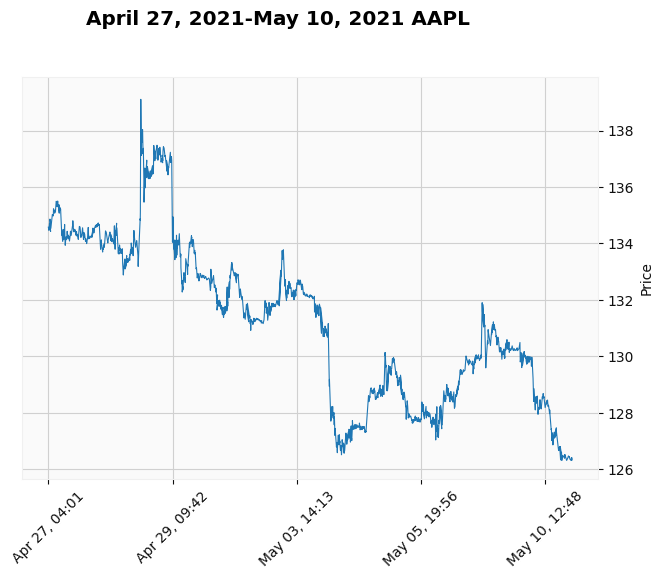

AAPL Returns
Strategy 1: 0.029%
Strategy 2: -0.219%
Strategy 3: -0.157%
Strategy 4: -0.194%
Market    : -0.741%
--------------------------------------------------


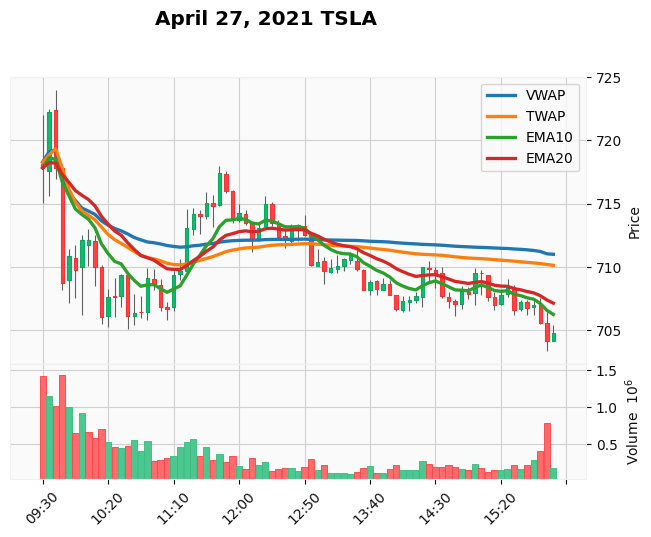

2021-04-27: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 6.966 TSLA short contracts at 717.82 per contract
11:25:00: Close 6.966 TSLA short contracts at 714.2101 per contract
11:25:00: Buy 7.036 TSLA shares at 714.2101 per share
13:00:00: Sell 7.036 TSLA shares at 710.4061 per share
13:00:00: Open 7.036 TSLA short contracts at 710.4061 per contract
16:00:00: Close 7.036 TSLA short contracts at 704.74 per contract
Cash: 5038.2465212593415
Return: 0.76%
Transactions: 6
----------------------------------------------------------------------
2021-04-27: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Buy 6.966 TSLA shares at 717.82 per share
16:00:00: Sell 6.966 TSLA shares at 704.74 per share
Cash: 4908.890808280627
Return: -1.82%
Transactions: 2
----------------------------------------------------------------------
2021-04-27: Starting EMA Cross strategy with $5000.0 USD
09:35:00: Buy 6.923 TSLA shares at 722.21 per share
09:45:00: Sell 6.923 TSLA shares at 708.750

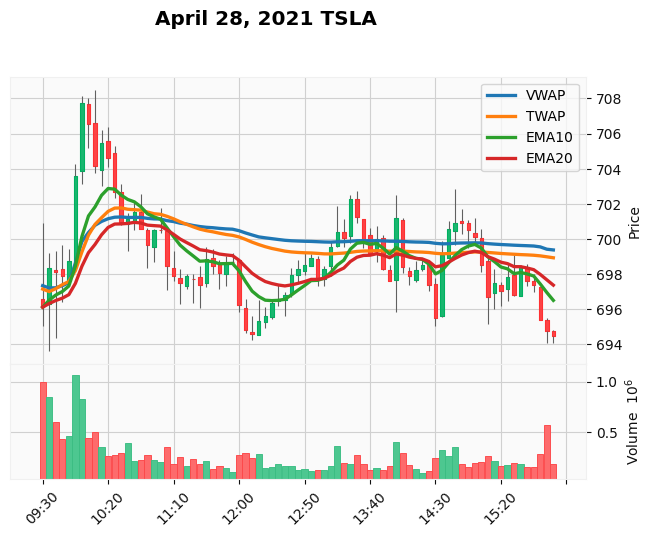

2021-04-28: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 7.183 TSLA short contracts at 696.0974 per contract
09:40:00: Close 7.183 TSLA short contracts at 698.1001 per contract
09:40:00: Buy 7.142 TSLA shares at 698.1001 per share
10:35:00: Sell 7.142 TSLA shares at 701.14 per share
10:35:00: Open 7.142 TSLA short contracts at 701.14 per contract
13:20:00: Close 7.142 TSLA short contracts at 700.034 per contract
13:20:00: Buy 7.164 TSLA shares at 700.034 per share
13:55:00: Sell 7.164 TSLA shares at 697.58 per share
13:55:00: Open 7.164 TSLA short contracts at 697.58 per contract
14:45:00: Close 7.164 TSLA short contracts at 700.9164 per contract
14:45:00: Buy 7.096 TSLA shares at 700.9164 per share
15:10:00: Sell 7.096 TSLA shares at 696.695 per share
15:10:00: Open 7.096 TSLA short contracts at 696.695 per contract
16:00:00: Close 7.096 TSLA short contracts at 694.46 per contract
Cash: 4959.644021824807
Return: -0.81%
Transactions: 14
---------------------------------

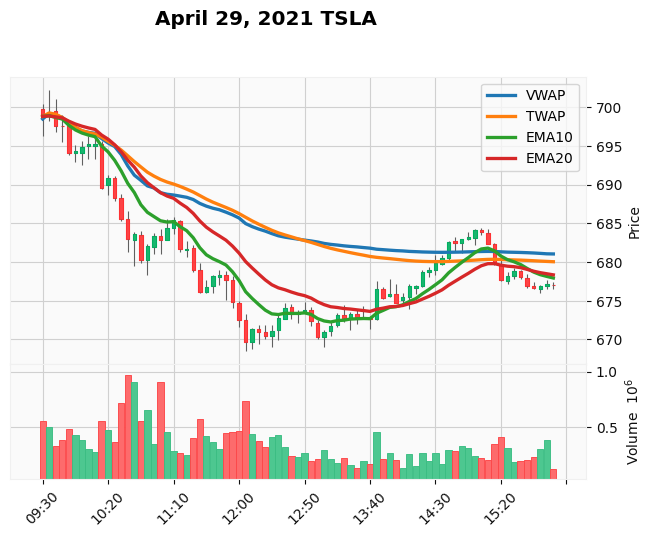

2021-04-29: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Buy 7.155 TSLA shares at 698.8046 per share
09:45:00: Sell 7.155 TSLA shares at 697.53 per share
09:45:00: Open 7.155 TSLA short contracts at 697.53 per contract
14:45:00: Close 7.155 TSLA short contracts at 682.4401 per contract
14:45:00: Buy 7.471 TSLA shares at 682.4401 per share
15:20:00: Sell 7.471 TSLA shares at 677.6895 per share
15:20:00: Open 7.471 TSLA short contracts at 677.6895 per contract
16:00:00: Close 7.471 TSLA short contracts at 677.0 per contract
Cash: 5068.507022408784
Return: 1.37%
Transactions: 8
----------------------------------------------------------------------
2021-04-29: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Open 7.155 TSLA short contracts at 698.8046 per contract
10:30:00: Close 7.155 TSLA short contracts at 685.5576 per contract
10:30:00: Buy 7.432 TSLA shares at 685.5576 per share
16:00:00: Sell 7.432 TSLA shares at 677.0 per share
Cash: 5031.186713188483
Return: 0.62%

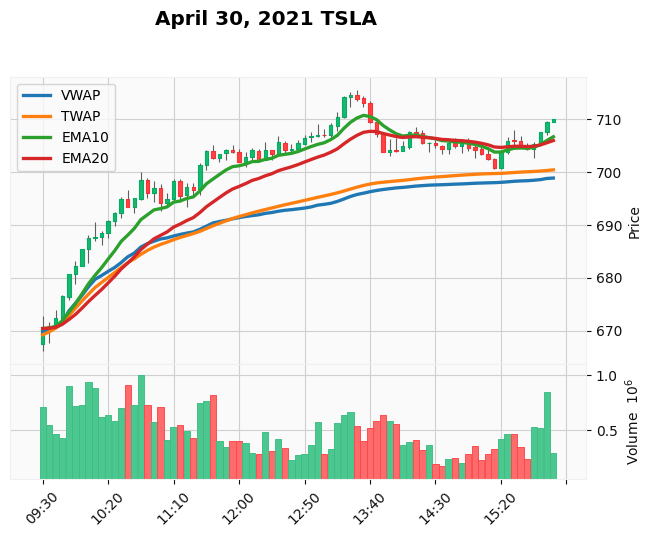

2021-04-30: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Buy 7.458 TSLA shares at 670.39 per share
16:00:00: Sell 7.458 TSLA shares at 709.84 per share
Cash: 5294.231715866884
Return: 5.88%
Transactions: 2
----------------------------------------------------------------------
2021-04-30: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Open 7.458 TSLA short contracts at 670.39 per contract
16:00:00: Close 7.458 TSLA short contracts at 709.84 per contract
Cash: 4705.768284133116
Return: -5.88%
Transactions: 2
----------------------------------------------------------------------
2021-04-30: Starting EMA Cross strategy with $5000.0 USD
09:35:00: Buy 7.452 TSLA shares at 670.9178 per share
14:30:00: Sell 7.452 TSLA shares at 705.09 per share
15:50:00: Buy 7.428 TSLA shares at 707.43 per share
16:00:00: Sell 7.428 TSLA shares at 709.84 per share
Cash: 5272.568624113797
Return: 5.45%
Transactions: 4
----------------------------------------------------------------------
202

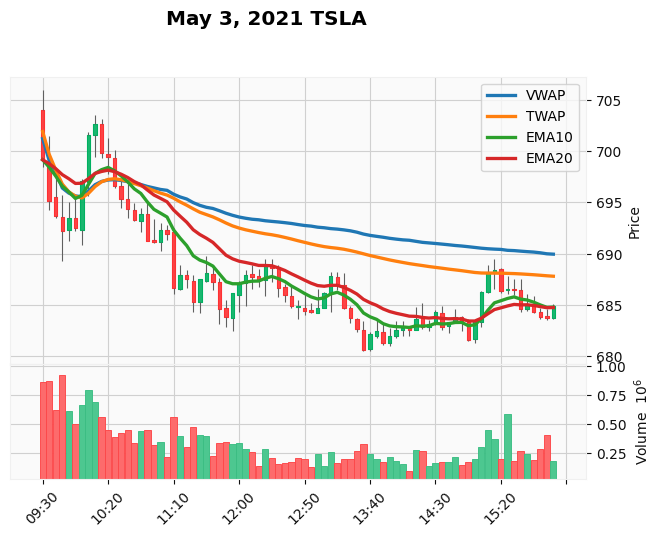

2021-05-03: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 7.151 TSLA short contracts at 699.16 per contract
10:05:00: Close 7.151 TSLA short contracts at 701.5678 per contract
10:05:00: Buy 7.102 TSLA shares at 701.5678 per share
10:30:00: Sell 7.102 TSLA shares at 695.3616 per share
10:30:00: Open 7.102 TSLA short contracts at 695.3616 per contract
16:00:00: Close 7.102 TSLA short contracts at 684.8748 per contract
Cash: 5013.183089178128
Return: 0.26%
Transactions: 6
----------------------------------------------------------------------
2021-05-03: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Buy 7.151 TSLA shares at 699.16 per share
16:00:00: Sell 7.151 TSLA shares at 684.8748 per share
Cash: 4897.840265461412
Return: -2.04%
Transactions: 2
----------------------------------------------------------------------
2021-05-03: Starting EMA Cross strategy with $5000.0 USD
10:10:00: Buy 7.116 TSLA shares at 702.64 per share
10:30:00: Sell 7.116 TSLA shares at 695.

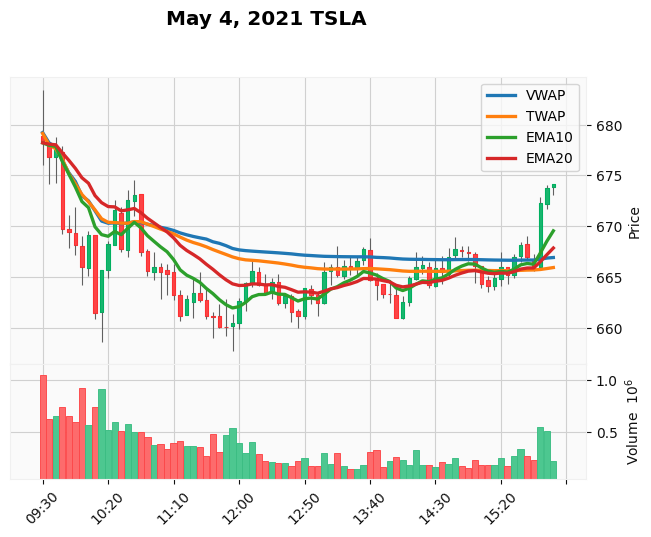

2021-05-04: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 7.372 TSLA short contracts at 678.21 per contract
10:40:00: Close 7.372 TSLA short contracts at 673.03 per contract
10:40:00: Buy 7.486 TSLA shares at 673.03 per share
10:50:00: Sell 7.486 TSLA shares at 665.58 per share
10:50:00: Open 7.486 TSLA short contracts at 665.58 per contract
14:45:00: Close 7.486 TSLA short contracts at 667.78 per contract
14:45:00: Buy 7.437 TSLA shares at 667.78 per share
15:05:00: Sell 7.437 TSLA shares at 664.31 per share
15:05:00: Open 7.437 TSLA short contracts at 664.31 per contract
15:35:00: Close 7.437 TSLA short contracts at 668.1339 per contract
15:35:00: Buy 7.351 TSLA shares at 668.1339 per share
16:00:00: Sell 7.351 TSLA shares at 674.18 per share
Cash: 4956.156564055607
Return: -0.88%
Transactions: 12
----------------------------------------------------------------------
2021-05-04: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Buy 7.372 TSLA shares at 678.21 per

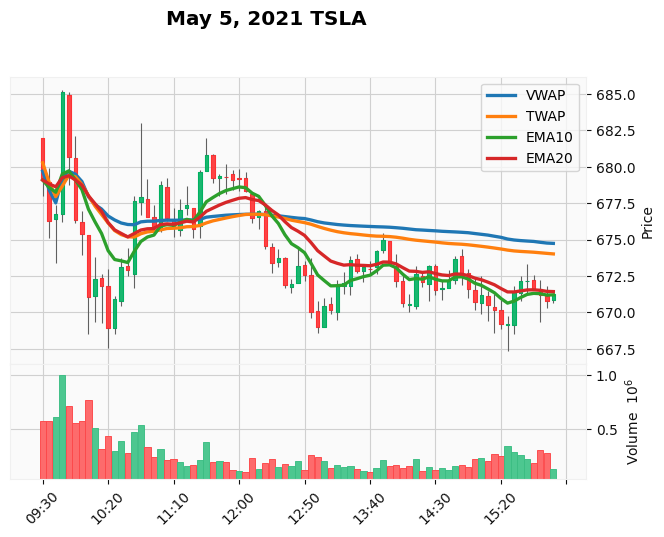

2021-05-05: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 7.363 TSLA short contracts at 679.0862 per contract
09:50:00: Close 7.363 TSLA short contracts at 680.67 per contract
09:50:00: Buy 7.329 TSLA shares at 680.67 per share
10:00:00: Sell 7.329 TSLA shares at 675.3799 per share
10:00:00: Open 7.329 TSLA short contracts at 675.3799 per contract
10:45:00: Close 7.329 TSLA short contracts at 677.9 per contract
10:45:00: Buy 7.274 TSLA shares at 677.9 per share
12:25:00: Sell 7.274 TSLA shares at 673.4019 per share
12:25:00: Open 7.274 TSLA short contracts at 673.4019 per contract
16:00:00: Close 7.274 TSLA short contracts at 671.28 per contract
Cash: 4913.81645525282
Return: -1.72%
Transactions: 10
----------------------------------------------------------------------
2021-05-05: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Buy 7.363 TSLA shares at 679.0862 per share
16:00:00: Sell 7.363 TSLA shares at 671.28 per share
Cash: 4942.5242333005735
Return: -1.15%


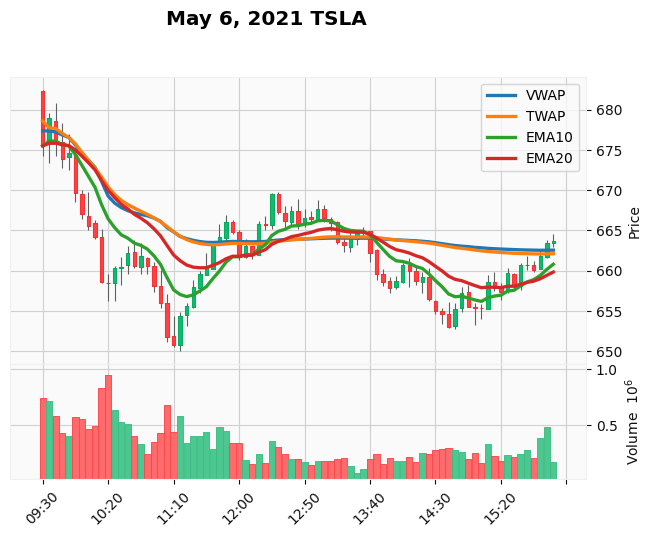

2021-05-06: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 7.402 TSLA short contracts at 675.48 per contract
11:45:00: Close 7.402 TSLA short contracts at 664.1301 per contract
11:45:00: Buy 7.655 TSLA shares at 664.1301 per share
12:05:00: Sell 7.655 TSLA shares at 663.0844 per share
12:05:00: Open 7.655 TSLA short contracts at 663.0844 per contract
12:20:00: Close 7.655 TSLA short contracts at 665.64 per contract
12:20:00: Buy 7.596 TSLA shares at 665.64 per share
13:20:00: Sell 7.596 TSLA shares at 663.1229 per share
13:20:00: Open 7.596 TSLA short contracts at 663.1229 per contract
13:35:00: Close 7.596 TSLA short contracts at 664.7742 per contract
13:35:00: Buy 7.559 TSLA shares at 664.7742 per share
13:45:00: Sell 7.559 TSLA shares at 659.55 per share
13:45:00: Open 7.559 TSLA short contracts at 659.55 per contract
16:00:00: Close 7.559 TSLA short contracts at 663.7 per contract
16:00:00: Buy 7.464 TSLA shares at 663.7 per share
16:00:00: Sell 7.464 TSLA shares at 6

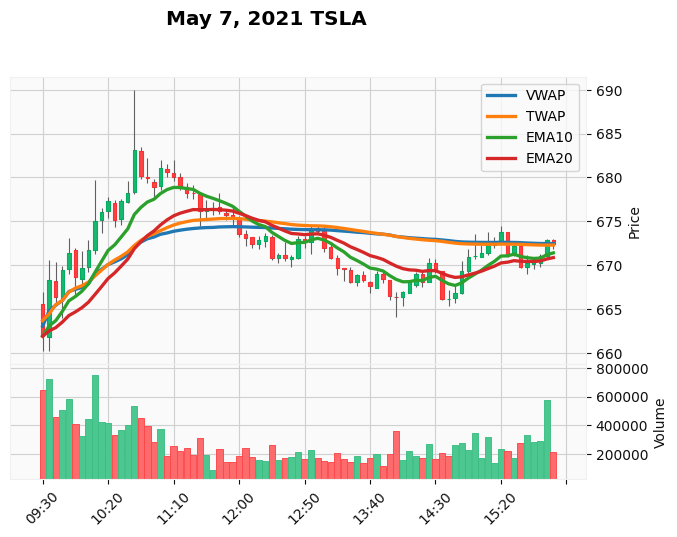

2021-05-07: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 7.554 TSLA short contracts at 661.9052 per contract
09:40:00: Close 7.554 TSLA short contracts at 666.3934 per contract
09:40:00: Buy 7.452 TSLA shares at 666.3934 per share
12:05:00: Sell 7.452 TSLA shares at 673.1462 per share
12:05:00: Open 7.452 TSLA short contracts at 673.1462 per contract
16:00:00: Close 7.452 TSLA short contracts at 672.36 per contract
Cash: 5022.278483042169
Return: 0.45%
Transactions: 6
----------------------------------------------------------------------
2021-05-07: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Buy 7.554 TSLA shares at 661.9052 per share
10:20:00: Sell 7.554 TSLA shares at 677.27 per share
10:20:00: Open 7.554 TSLA short contracts at 677.27 per contract
13:55:00: Close 7.554 TSLA short contracts at 666.47 per contract
13:55:00: Buy 7.799 TSLA shares at 666.47 per share
16:00:00: Sell 7.799 TSLA shares at 672.36 per share
Cash: 5243.58240661376
Return: 4.87%
Tr

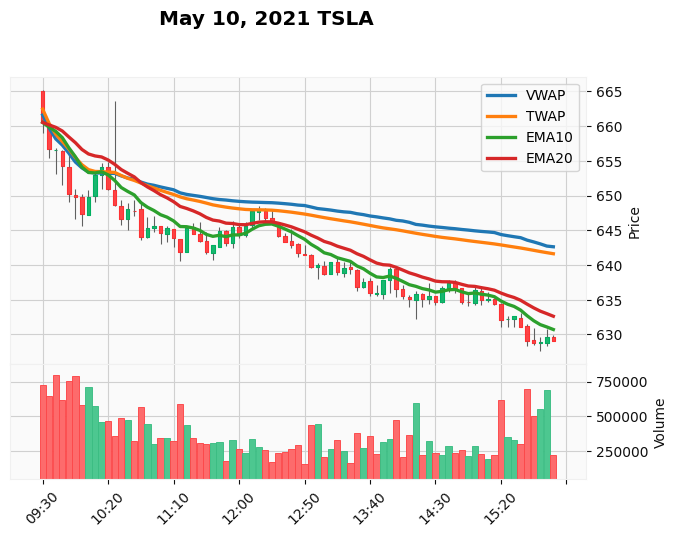

2021-05-10: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 7.570 TSLA short contracts at 660.53 per contract
16:00:00: Close 7.570 TSLA short contracts at 629.04 per contract
Cash: 5238.369188379029
Return: 4.77%
Transactions: 2
----------------------------------------------------------------------
2021-05-10: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Buy 7.570 TSLA shares at 660.53 per share
16:00:00: Sell 7.570 TSLA shares at 629.04 per share
Cash: 4761.630811620971
Return: -4.77%
Transactions: 2
----------------------------------------------------------------------
2021-05-10: Starting EMA Cross strategy with $5000.0 USD
16:00:00: Sell 0.000 TSLA shares at 629.04 per share
Cash: 5000.0
Return: 0.00%
Transactions: 1
----------------------------------------------------------------------
2021-05-10: Starting VWAP + TWAP strategy with $5000.0 USD
09:30:00: Open 7.570 TSLA short contracts at 660.53 per contract
16:00:00: Close 7.570 TSLA short contracts at 629

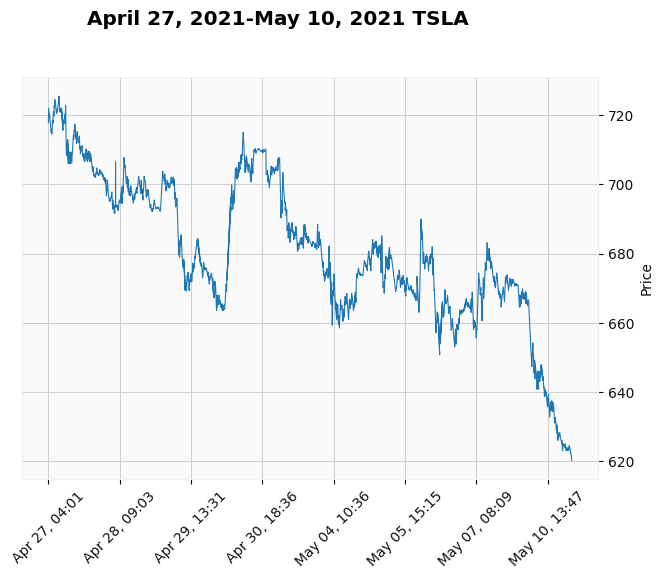

TSLA Returns
Strategy 1: 0.917%
Strategy 2: -0.906%
Strategy 3: 0.014%
Strategy 4: 1.041%
Market    : -1.118%
--------------------------------------------------
Portfolio Returns
Strategy 1: 0.473%
Strategy 2: -0.563%
Strategy 3: -0.071%
Strategy 4: 0.423%
Market    : -0.929%


In [12]:
portfolio = ['AAPL','TSLA'] 
cash = 100000 
show_transactions = True
show_graphs       = True 
main(portfolio,cash,show_transactions,show_graphs) 